# 4. Independent component analysis

In the previous tutorial, we transformed seismic data into scattering coefficients using a scattering network.

Scattering coefficients contain high-level information but in a high-dimensional space that can be cumbersome to analyze. In this tutorial, we use dimensionality reduction techniques to extract the most relevant information into a few key features that are easier to work with and visualize.

In [29]:
import pickle

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.metrics import explained_variance_score

In [30]:
%config InlineBackend.figure_format = "svg"

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for dimensionality reduction. The scattering coefficients from the previous notebook come in separate arrays for each order, but we need to combine them into a single two-dimensional matrix where each row represents a time segment and each column represents a feature.

In [31]:
# Load data from file
with np.load(
    "../example/scattering_coefficients.npz", allow_pickle=True
) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
coefficients = np.hstack((order_1, order_2))

# transform into log
coefficients = np.log10(coefficients)

# Normalize between 0 and 1
coefficients = (coefficients - coefficients.min()) / (
    coefficients.max() - coefficients.min()
)

# print info about shape
n_times, n_coeff = coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 4319 samples of 504 dimensions each.


## Apply independent component analysis

### Choosing the number of components

Independent component analysis (ICA) is another dimensionality reduction technique that separates mixed signals into independent components. Unlike principal component analysis (PCA) which finds orthogonal directions of maximum variance, ICA finds statistically independent sources.

In order to decide the number of components we should use, we vary the number of components and observe the explained variance or reconstruction error.  The `FastICA` algorithm, included in the [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) package, is one of the most common algorithms to perform ICA. It factorizes the data matrix (in our case scattering coefficient matrix) into an independent source matrix and a mixing matrix. The `n_components` keyword argument informs the model about how many components (or features, or sources) we want to extract. The residual shape of the `components` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above. Setting the `random_state` parameter to an integer helps to reproduce the same results, which might be important if you want to test different model parameters.

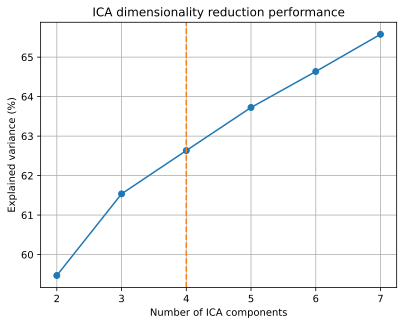

In [32]:
n_components = np.arange(2, 8)
explained = np.zeros(len(n_components))
for i, n in enumerate(n_components):
    ica = FastICA(n, whiten="unit-variance", random_state=42, tol=1e-1)
    ica_features = ica.fit_transform(coefficients)
    reconstructed = ica.inverse_transform(ica_features)
    explained[i] = explained_variance_score(coefficients, reconstructed)

n_chosen = 4

fig, ax = plt.subplots()
ax.plot(n_components, explained * 100, marker="o")
ax.axvline(n_chosen, color="C1", linestyle="--")
ax.set_xlabel("Number of ICA components")
ax.set_ylabel("Explained variance (%)")
ax.set_title("ICA dimensionality reduction performance")
ax.grid()

### Apply ICA with chosen number of components

In [33]:
ica_model = FastICA(n_components=4, whiten="unit-variance", random_state=42)
ica_features = ica_model.fit_transform(coefficients)
features = ica_features / np.max(np.abs(ica_features), axis=0)

# Explained ica variance
reconstructed = ica_model.inverse_transform(ica_features)
explained = explained_variance_score(coefficients, reconstructed)

# Log
print(f"Explained variance by ICA components: {explained:.2%}%")

Explained variance by ICA components: 62.63%%


### Show features time series

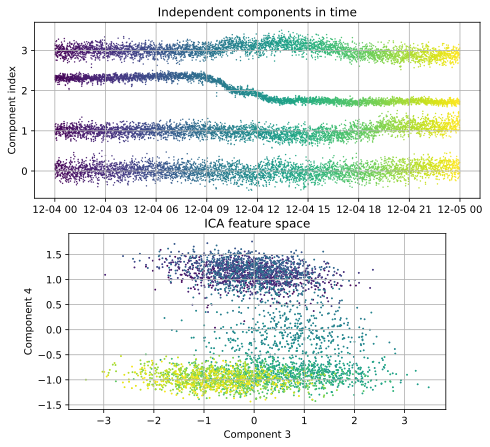

In [34]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 7), dpi=300)
t = np.arange(len(times))

# Independent components in time
for i, feature in enumerate(features.T):
    ax[0].scatter(
        times, feature / 2 + i, rasterized=True, c=t, s=2, linewidths=0
    )
ax[0].set_ylabel("Component index")
ax[0].set_title("Independent components in time")
ax[0].grid()


# Plot the first two principal components
ax[1].scatter(*ica_features[:, [3, 2]].T, s=1, c=mdates.date2num(times))
ax[1].set_ylabel("Component 4")
ax[1].set_xlabel("Component 3")
ax[1].set_aspect("equal")
ax[1].set_title("ICA feature space")
ax[1].grid()

# Show
plt.show()

## Interpret ICA results

The 4 features from ICA look similar to the first 4 features of PCA, however the ranking is different. The ranking of ICA has no importance—ICA does not sort its components after an eigenvalue as PCA does. If we do not fix the `random_state` parameter, the ranking and sign of the components might change with each run. On the right, we show the two ICA features which contain similar information to the first two PCA features.

## Save the output

We save the extracted features from the ICA model as a npz-file for other downstream tasks, just like we saved the scattering coefficients in the previous notebook.

In [35]:
# Save the features
np.savez(
    "../example/independent_components.npz",
    features=ica_features,
    times=times,
)

# Save the dimension reduction model
with open("../example/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        ica_model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )